In [2]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


In [3]:
DATASET_PATH = r"C:\Users\USER\Desktop\Song_dataset"
genres = ["rap", "melody"]

X, y = [], []
SAMPLE_RATE = 22050  # standard librosa sample rate
CLIP_DURATION = 10   # seconds
CLIP_SAMPLES = SAMPLE_RATE * CLIP_DURATION

for genre in genres:
    folder = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        try:
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            # Split song into multiple 10-sec clips
            for start in range(0, len(signal), CLIP_SAMPLES):
                clip = signal[start:start+CLIP_SAMPLES]
                
                if len(clip) == CLIP_SAMPLES:  # only full clips
                    mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=40)
                    mfcc = mfcc.T  # (time_steps, n_mfcc)
                    
                    X.append(mfcc)
                    y.append(genre)
        except:
            print("Error with:", file)


In [4]:
X = np.array(X)
y = np.array(y)

encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)


X_train shape: (794, 431, 40)
y_train shape: (794, 2)


In [5]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1], activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               86528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 94,914
Trainable params: 94,914
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # track validation accuracy
    patience=3,               # stop if no improvement for 3 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/25
100/100 [==============================] - 18s 155ms/step - loss: 0.6098 - accuracy: 0.6738 - val_loss: 0.4136 - val_accuracy: 0.8040
Epoch 2/25
100/100 [==============================] - 15s 147ms/step - loss: 0.3827 - accuracy: 0.8300 - val_loss: 0.3381 - val_accuracy: 0.8492
Epoch 3/25
100/100 [==============================] - 15s 148ms/step - loss: 0.3380 - accuracy: 0.8564 - val_loss: 0.2473 - val_accuracy: 0.8995
Epoch 4/25
100/100 [==============================] - 16s 155ms/step - loss: 0.1829 - accuracy: 0.9307 - val_loss: 0.2194 - val_accuracy: 0.8945
Epoch 5/25
100/100 [==============================] - 15s 149ms/step - loss: 0.1800 - accuracy: 0.9219 - val_loss: 0.2198 - val_accuracy: 0.9146
Epoch 6/25
100/100 [==============================] - 15s 153ms/step - loss: 0.1251 - accuracy: 0.9572 - val_loss: 0.1594 - val_accuracy: 0.9497
Epoch 7/25
100/100 [==============================] - 15s 150ms/step - loss: 0.1377 - accuracy: 0.9408 - val_loss: 0.1280 - val_ac

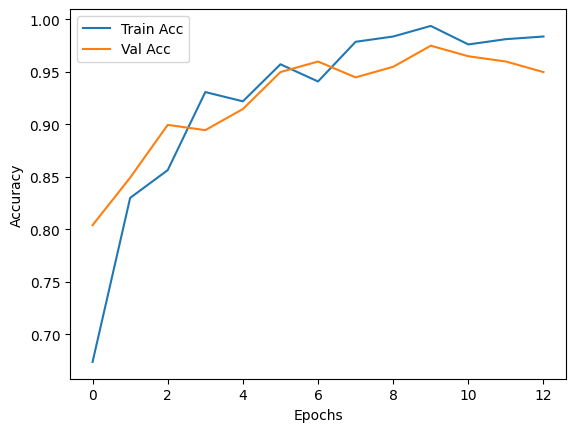

In [7]:
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


7/7 [==============================] - 1s 67ms/step - loss: 0.0795 - accuracy: 0.9749
Test Accuracy: 97.49%


In [9]:
import numpy as np
import librosa

def predict_genre(file_path, model, encoder, sr=22050, clip_duration=10, n_mfcc=40):
    """
    Predict genre of a new song using trained LSTM model.
    """
    clip_samples = sr * clip_duration
    predictions = []

    # Load song
    signal, _ = librosa.load(file_path, sr=sr)

    # Split into clips
    for start in range(0, len(signal), clip_samples):
        clip = signal[start:start+clip_samples]

        if len(clip) == clip_samples:
            # Extract MFCC
            mfcc = librosa.feature.mfcc(y=clip, sr=sr, n_mfcc=n_mfcc)
            mfcc = mfcc.T  # (timesteps, features)

            # Reshape for LSTM (1 sample, timesteps, features)
            mfcc = np.expand_dims(mfcc, axis=0)

            # Predict
            pred = model.predict(mfcc, verbose=0)
            pred_class = np.argmax(pred, axis=1)[0]
            predictions.append(pred_class)

    # Majority vote
    if len(predictions) > 0:
        final_class = max(set(predictions), key=predictions.count)
        return encoder.inverse_transform([final_class])[0]
    else:
        return "Not enough data"


In [10]:
# Example usage:
file_path = r"C:\Users\USER\Downloads\Thangapoovey.mp3"   # put your test song path here
predicted_genre = predict_genre(file_path, model, encoder)
print("Predicted Genre:", predicted_genre)


Predicted Genre: melody


In [11]:
# Example usage:
file_path = r"C:\Users\USER\Downloads\Powerhouse.mp3"   # put your test song path here
predicted_genre = predict_genre(file_path, model, encoder)
print("Predicted Genre:", predicted_genre)


Predicted Genre: rap
